In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

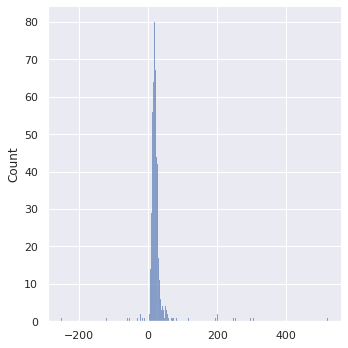

In [15]:
features = pd.read_csv('constituents-financials_csv.csv', sep=',')
features['Price/Earnings'].fillna(features['Price/Earnings'].mean())
P_E = features['Price/Earnings'].to_numpy()
sns.displot(P_E, kde = False)

(array([], dtype=int64),)


/home/elizabeth/labs/labs_venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


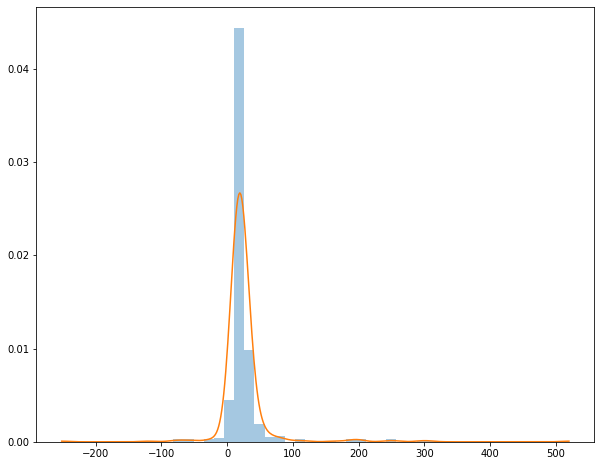

In [7]:
#Replace NaN values in array to mean value
col_mean = np.nanmean(P_E, axis=0)
inds = np.where(np.isnan(P_E))
print(inds)
P_E[inds] = col_mean

plt.figure(figsize=(10, 8))

kernel = scipy.stats.gaussian_kde(P_E)

min_amount, max_amount = P_E.min(), P_E.max()
x = np.linspace(min_amount, max_amount, len(P_E))
kde_values = kernel(x)

sns.distplot(P_E, kde=False, norm_hist=True, label=f'Price\Earning ratio')
plt.plot(x, kde_values)
plt.savefig('hist_kernel.png')

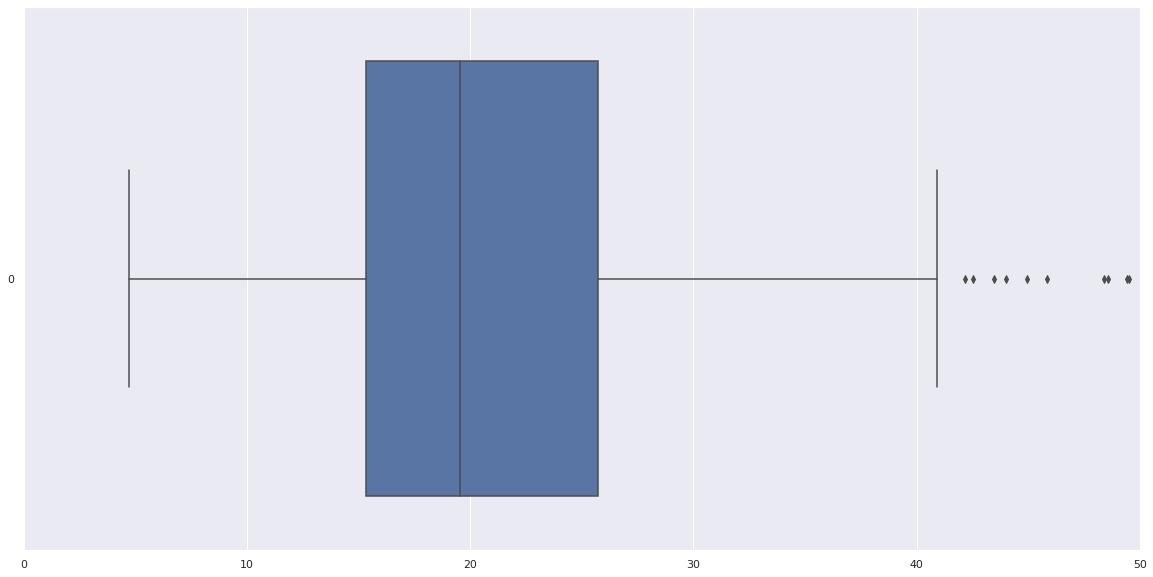

In [8]:
#Build a box with whiskers
sns.set(rc={'figure.figsize':(20, 10)})
a = sns.boxplot(data=P_E, orient='h')
a.set(xlim=(0, 50))
plt.savefig('boxplot1.png')

In [9]:
#Count quartiles and "whiskers"
Q1, Q3 = features['Price/Earnings'].quantile([0.25,0.75])
right_whisker = Q3 + 1.5*(Q3-Q1)
left_whisker = Q1 - 1.5*(Q3-Q1)
print ('1/4 qauntile = ', Q1, ' 3/4 qauntile = ' , Q3, 'IQR = ', Q1-Q3)
print ('Medain = ', np.median(P_E))

1/4 qauntile =  15.35  3/4 qauntile =  25.74 IQR =  -10.389999999999999
Medain =  19.54


In [10]:
#Trim data
Left_trim = (np.count_nonzero(P_E < left_whisker, axis=0))/P_E.shape[0]
P_E_trimmed = scipy.stats.trim1(P_E, Left_trim, 'left')
Right_trim = (np.count_nonzero(P_E > right_whisker, axis=0)) /P_E_trimmed.shape[0]
P_E_trimmed = scipy.stats.trim1(P_E_trimmed, Right_trim, 'right')
print(f'max_P/E ratio ', np.max(P_E), ' min_P/E ratio ', np.min(P_E))
print(f'max trimmed P/E ratio ', np.max(P_E_trimmed),
      ' min trimmed P/E ratio ', np.min(P_E_trimmed))


max_P/E ratio  520.15  min_P/E ratio  -251.53
max trimmed P/E ratio  40.9  min trimmed P/E ratio  4.7


(19.853420915554707, 6.720882596350933)


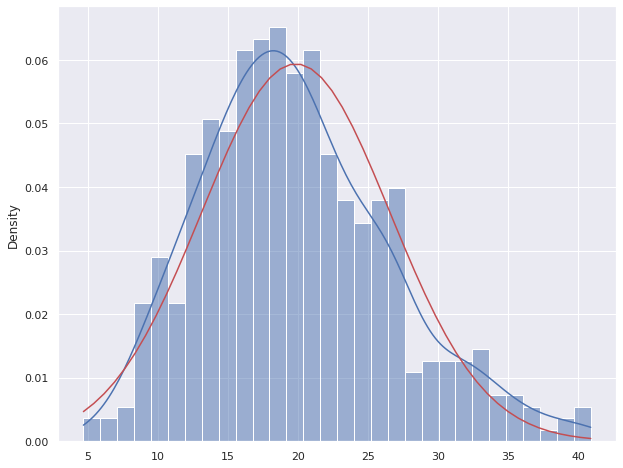

<Figure size 1440x720 with 0 Axes>

In [11]:
#Params are calculated by MLE and MLS for normal distribution (finally we get the same estimations for all methods and E~mean, sigma^2)
params = scipy.stats.norm.fit(P_E_trimmed)
print (params)
plt.figure(figsize=(10, 8))
x = np.linspace(np.min(P_E_trimmed), np.max(P_E_trimmed))
sns.histplot(P_E_trimmed, kde=True, bins=30, stat='density', label=f'P/B')
plt.plot(x, scipy.stats.norm.pdf(x, params[0], params[1]), 'r')
plt.show()
plt.savefig('theo+empir.png')


In [12]:
ks = scipy.stats.kstest(P_E_trimmed, 'norm', params, N=100)
chi2 = scipy.stats.chisquare(P_E_trimmed)
print (ks)
print("%.54f" % (chi2.pvalue))


KstestResult(statistic=0.05358867262767053, pvalue=0.13892052203198513)
0.000000000000000000000000000000000000000000000011690117


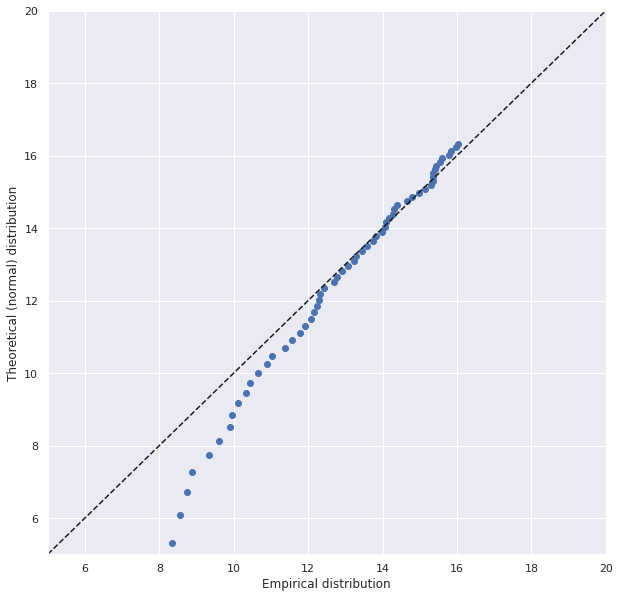

In [14]:
percs = np.linspace(0, 30, 60)
qn_first = np.percentile(P_E_trimmed, percs)
qn_norm = scipy.stats.norm.ppf(percs / 100.0, *params)
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(5, 20)
plt.ylim(5, 20)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (normal) distribution')
plt.savefig('biplot1.png')